Background 
This script demonstrates the convolution of a single (or multiple) time-constant eddy current impulse response function (EC-IRF), e(t), with a monopolar (or bi-polar) trapezoidal gradient waveform. Recall, 

$$e(t)=H(t)\sum_n\alpha_n e^{-\frac{t}{\tau_n}}$$

Each EC-IRF has an amplitude $\alpha_n$ and time constant $\tau$ [s]. Herein, we consider the effect of the eddy current response on the gradient field that is generated. The eddy currents can effect any gradient axis and, in fact, the  gradient can induce an eddy current on the  or  axes, which we call "cross terms". Herein, we will examine the eddy current gradient () that is generated along the x-axis by the application of a  gradient, which we term . This arises from time-varying active gradients that induce currents in nearby conducting structures (e.g. cryostat). These induced currents create magnetic fields that oppose (Lenz's Law) the target magnetic field. They are generated during active gradient slewing and decay during periods of gradient inactivity. 

$$G_{eddy,xx}(t)=\left( -\frac{dG_x(t)}{dt} \ast \sum_n \alpha_{xx,n} e^{-\frac{t}{\tau_{xx,n}}} \right)\hat{k}$$

We are examing the impact of eddy currents on the gradient waveform because it is a little easuer to visualize. Eddy currents also modulate the  field and cause and, in general,  is different for each gradient axis. You can read more about this in the "Handbook of MRI Pulse Sequences" by Matt Bernstein and colleagues. See Chapter 10.3.

QUESTIONS

1. Try a range of ECIR time constants. What kinds of time constants cause a $B_0$ field offset after the monopolar gradient?
     - Hint: Set the variable "tau"

Code Co-Creation: Matt Middione and DBE@STANFORD.EDU (April 2021) for Rad229
First Python version by dbe@stanford.edu (April 2025) for Rad229

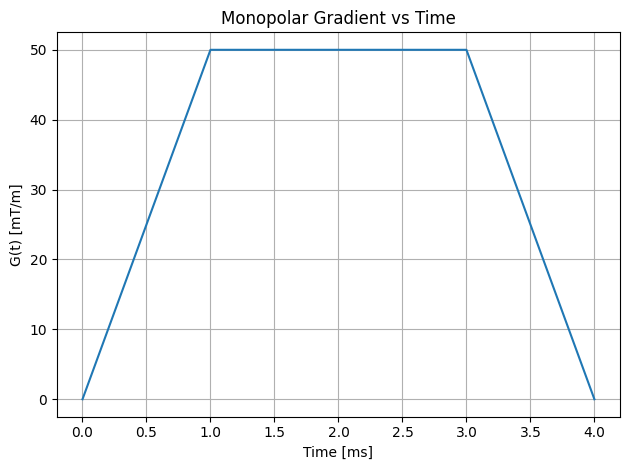

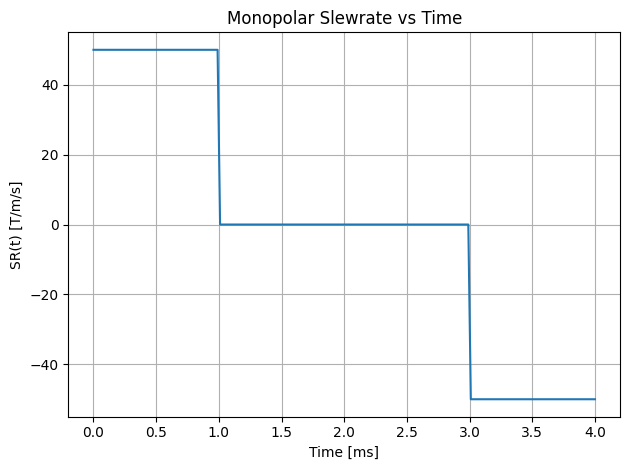

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define some system variables
B0 = 3.0  # [T]
gamma = 267.52e6 # Gyromagnetic ratio [rad/s/T]; 2*pi*42.57 MHz/T
gMax = 50e-3  # [T/m]
sMax = 50  # [T/m/s]
dt = 10e-6  # Time step [s]
dG = sMax * dt  # Gradient "step" [T/m] (this is the fastest step possible)

# Define a monopolar gradient waveform
G_rise = np.arange(0, gMax, dG)   # Gradient ramp-up
G_flat_dur = 1e-3 # Gradient flat-top duration [s]
G_flat = gMax * np.ones(int(G_flat_dur/dt))
G_fall = np.arange(gMax, 0 - dG, -dG) # Gradient ramp-down
Gx = np.concatenate((G_rise, G_flat, G_fall)) # Composite gradient waveform

# Calculate lengths of each gradient segment
n_rise = len(G_rise)
n_flat = len(G_flat)
n_fall = len(G_fall)

tvec = np.arange(0, dt * len(Gx), dt)  # Time vector

# Calculate the slewrate waveform [T/m/s]
#SRx = np.append(np.diff(Gx), 0) / dt 
SRx = np.gradient(Gx, dt)

# Split SRx into segments
SRx_rise = np.zeros_like(SRx)
SRx_fall = np.zeros_like(SRx)

# Insert the appropriate segments
SRx_rise[:n_rise] = SRx[:n_rise]
SRx_fall[n_rise + n_flat:] = SRx[n_rise + n_flat:]

plt.figure
plt.plot(tvec*1e3, Gx*1e3)
plt.xlabel('Time [ms]')
plt.ylabel('G(t) [mT/m]')
plt.title('Monopolar Gradient vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure
plt.plot(tvec*1e3, SRx)
plt.xlabel('Time [ms]')
plt.ylabel('SR(t) [T/m/s]')
plt.title('Monopolar Slewrate vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

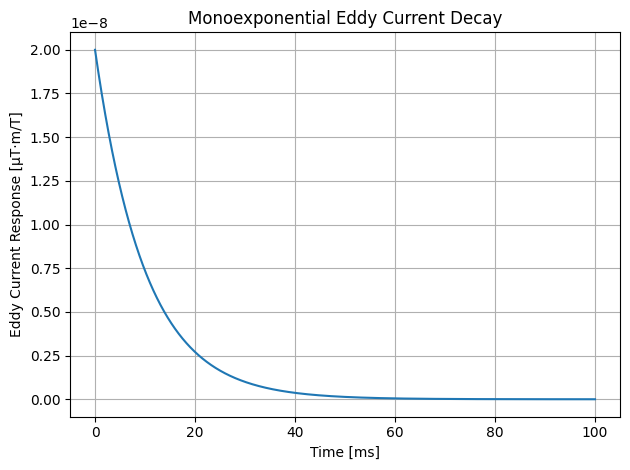

In [ ]:
# Define some eddy current parameters
tau = [5000e-6]  # [s]
alpha = [0.02e-6]  # [µT·m/T]
tvec_eddy = np.arange(0, 10 * max(tau) + dt, dt)  # Time vector [s]

# If you want to add a second eddy current component, uncomment this:
# tau.append(5.0e-3)                # Second time constant [s]
# alpha.append(5.0e-6)              # Second amplitude [µT·m/T]

# Compute sum of monoexponential eddy current impulse responses (ecir)
ecir = np.zeros_like(tvec_eddy)
for tau_i, alpha_i in zip(tau, alpha):
    ecir += alpha_i * np.exp(-tvec_eddy / tau_i)

plt.figure
plt.plot(tvec_eddy * 1e3, ecir)  # Convert time to milliseconds for the x-axis
plt.xlabel('Time [ms]')
plt.ylabel('Eddy Current Response [µT·m/T]')
plt.title('Monoexponential Eddy Current Decay')
plt.grid(True)
plt.tight_layout()
plt.show()

Define the resultant B_0 eddy current field

$$  \vec{B}_{0,eddy}(t)=\left( -\frac{d\vec{G}(t)}{dt} \ast \sum_n \alpha_n e^{-\frac{t}{\tau_n}} \right)\hat{k} $$

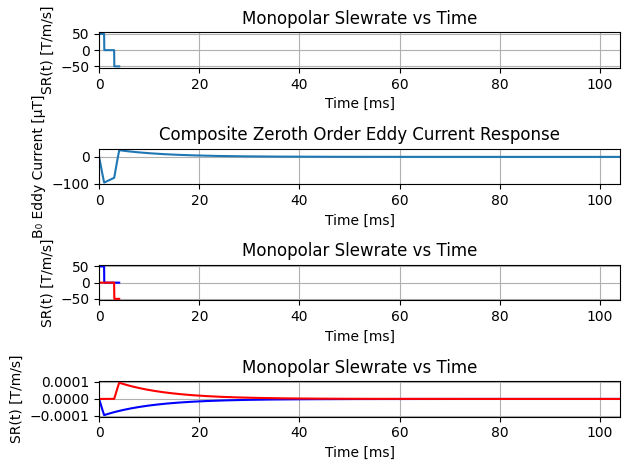

In [7]:
# Compute ZEROTH order eddy current [µT]
B0_e = np.convolve(-SRx, ecir)
B0_e_rise = np.convolve(-SRx_rise, ecir)
B0_e_fall = np.convolve(-SRx_fall, ecir)

# Time vector corresponding to B0_e
tvec_e = np.arange(0, dt * len(B0_e), dt)
max_time = max(np.max(tvec_e), np.max(tvec))

plt.figure

plt.subplot(4, 1, 1)
plt.plot(tvec*1e3, SRx)
plt.xlabel('Time [ms]')
plt.ylabel('SR(t) [T/m/s]')
plt.title('Monopolar Slewrate vs Time')
plt.xlim(0, max_time * 1e3)  # Set x-axis limit to max time in milliseconds
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(tvec_e * 1e3, B0_e*1e6)  # Convert time to milliseconds
plt.xlabel('Time [ms]')
plt.ylabel('B₀ Eddy Current [µT]')
plt.title('Composite Zeroth Order Eddy Current Response')
plt.xlim(0, max_time * 1e3)  # Set x-axis limit to max time in milliseconds
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(tvec * 1e3, SRx_rise, label='SRx Rise', color='blue')
plt.plot(tvec * 1e3, SRx_fall, label='SRx Fall', color='red')
plt.xlabel('Time [ms]')
plt.ylabel('SR(t) [T/m/s]')
plt.title('Monopolar Slewrate vs Time')
plt.xlim(0, max_time * 1e3)  # Set x-axis limit to max time in milliseconds
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(tvec_e * 1e3, B0_e_rise, label='B0 Eddy Gradient Rise', color='blue')
plt.plot(tvec_e * 1e3, B0_e_fall, label='B0 Eddy Gradient Fall', color='red')
plt.xlabel('Time [ms]')
plt.ylabel('SR(t) [T/m/s]')
plt.title('Monopolar Slewrate vs Time')
plt.xlim(0, max_time * 1e3)  # Set x-axis limit to max time in milliseconds
plt.grid(True)


plt.tight_layout()
plt.show()

We observe that this eddy current can impart a  field shift of about 100 µT during the application of the gradient, which accords with ~4257Hz in frequency. Note that the eddy current field persists for some time after the gradient is off. Note too that $\alpha$ was picked somewhat arbitrarily.

Now define the resultant eddy current gradient, $G_{eddy,x}$. For now just assume the same eddy current impulse response function with a 10x $\alpha$ is acceptable. In general, there is no reason they should be the same. Note the resultant units are different so the $\alpha$ coefficient carries different units too.

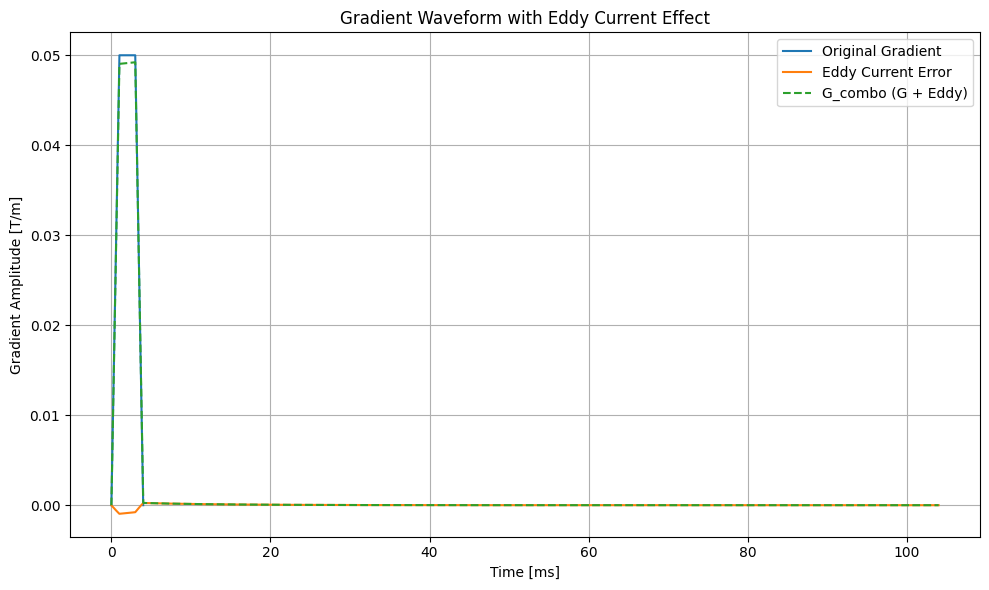

In [8]:
# Compute FIRST order X-gradient eddy current effect (self-term)
Gxx_e = np.convolve(-SRx, 10*ecir)

G_padded = np.pad(Gx, (0, len(Gxx_e) - len(Gx)), mode='constant')

G_combo = G_padded + Gxx_e

# Time vector based on the length of G (adjust if you used a padded version)
t_combo = np.arange(len(G_combo)) * dt  # in seconds

plt.figure(figsize=(10, 6))
plt.plot(tvec * 1e3, Gx, label='Original Gradient')         # Convert to ms
plt.plot(t_combo * 1e3, Gxx_e, label='Eddy Current Error')
plt.plot(t_combo * 1e3, G_combo, label='G_combo (G + Eddy)', linestyle='--')

plt.xlabel('Time [ms]')
plt.ylabel('Gradient Amplitude [T/m]')
plt.title('Gradient Waveform with Eddy Current Effect')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


What you observe is that you don't quite get the targeted gradient design because the eddy current induced gradient field always apposes the applied field according to Lenz's Law. What are the consequences? What can you do about it?